<a href="https://colab.research.google.com/github/Timure228/LSTM_Based_Text_Generator/blob/main/LSTM_Gen_Chars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Chars Generator

In [1]:
import torch
from torch import nn
from torch.nn import RNN, LSTM, Dropout

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import regex
import string

import numpy as np

In [2]:
FILE = "lstb.txt"
with open(FILE, "r") as f:
  lines_amount = f.read().count("\n") + 1

lines_amount

7841

In [3]:
translator = str.maketrans('', '', string.punctuation)

In [4]:
import re

with open(FILE, "r") as f:
  text = f.read()
  text = text.strip().translate(translator).lower()
  text = text[:int(len(text)*0.5) + 1]
  print(text.count("\n") + 1)

# print(f"Before: {len(text)}")

# text = re.sub('\)', '',text)
# text = re.sub('\(', '',text)

# for pattern in set(re.findall('<unk>', text)):
#   text = re.sub(pattern, '', text)

# print(f"After: {len(text)}")

3913


In [5]:
train_text = text[:int(len(text)*0.8)]
test_text = text[int(len(text)*0.8):]

In [6]:
# Tokenize
tokens = []
for i in text:
  tokens.append(i)

print("word", max(set(tokens), key=tokens.count))

tokens = list(set(tokens))
vocab_size = len(tokens)
sorted(tokens), vocab_size

word  


(['\n',
  ' ',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'à',
  'é',
  'ê'],
 41)

In [7]:
indx_to_token = {indx: token for indx, token in enumerate(tokens)}
token_to_indx = {token: indx for indx, token in enumerate(tokens)}

In [8]:
# Create encode and decode function
def encode(arr: list, token_to_indx=token_to_indx):
  for i in arr:
    for j in range(len(i)):
      i[j] = token_to_indx[i[j]]
  return arr

def decode(arr: list, indx_to_token=indx_to_token):
  for i in arr:
    for j in range(len(i)):
      i[j] = indx_to_token[i[j]]
  return arr

In [9]:
SEQ_LENGTH = 10

def create_sequence(X: list, y: list, text: str, SEQ_LENGTH = SEQ_LENGTH, STEP=1):
  for i in range(0, len(text)- SEQ_LENGTH, STEP):
    chars = []
    for j in range(i, i + SEQ_LENGTH):
      chars.append(text[j])
    X.append(chars)

    y.append([text[i+SEQ_LENGTH]])
  return X, y

In [10]:
# Creating the sequences
X_train = []
y_train = []

X_test = []
y_test = []

X_train, y_train = create_sequence(X_train, y_train, train_text, SEQ_LENGTH=10)
X_test, y_test = create_sequence(X_test, y_test, test_text, SEQ_LENGTH=10)

X_test[1], y_test[1]

([' ', ' ', ' ', 'e', 'd', 'u', 'c', 'a', 't', 'i'], ['o'])

In [11]:
# Encoding, converting to numerical
X_train = encode(X_train)
y_train = encode(y_train)

In [153]:
X_test = encode(X_test)
y_test = encode(y_test)

In [12]:
# Padding X
X_train_padded = pad_sequences(X_train, maxlen=10, padding='post', value=0)  # 'post' means pad at the end of each sequence

# X_test_padded = pad_sequences(X_test, maxlen=10, padding='post', value=0)

In [13]:
# Converting X and y to categorical vectors
X_train_cat = to_categorical(X_train_padded, num_classes=vocab_size)
y_train_cat = to_categorical(y_train, num_classes=vocab_size)

In [158]:
X_test_cat = to_categorical(X_test_padded, num_classes=vocab_size)
y_test_cat = to_categorical(y_test, num_classes=vocab_size)

In [316]:
# Check the ranks of X and y
print(f"X Rank: {tf.rank(X_train_cat)} | y Rank: {tf.rank(y_train_cat)}")
print(f"X Shape: {X_train_cat.shape} | y shape: {y_train_cat.shape}")
print(f"X Type: {type(X_train_cat)} | y Type: {type(y_train_cat)}")

X Rank: 3 | y Rank: 2
X Shape: (30818, 10, 34) | y shape: (30818, 34)
X Type: <class 'numpy.ndarray'> | y Type: <class 'numpy.ndarray'>


In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Input

# TensorFlow Based

In [15]:
model = Sequential()
model.add(Input(shape=(SEQ_LENGTH, vocab_size)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='softmax'))
model.add(Dropout(rate=0.5))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [16]:
history = model.fit(x=X_train_cat, y=y_train_cat, batch_size=128, shuffle=True, epochs=30, verbose=1)

Epoch 1/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2253 - loss: 3.3281
Epoch 2/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2423 - loss: 2.9220
Epoch 3/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2427 - loss: 2.8247
Epoch 4/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.2414 - loss: 2.7997
Epoch 5/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2420 - loss: 2.7884
Epoch 6/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.2423 - loss: 2.7878
Epoch 7/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.2422 - loss: 2.7841
Epoch 8/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2406 - loss: 2.7849
Epoch 9/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2422 - loss: 2.7829
Epoch 10/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2416 - loss: 2.7826
Epoch 11/30
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.2415 - loss: 2.7837
Epoch 12/30
1205/1205 ━

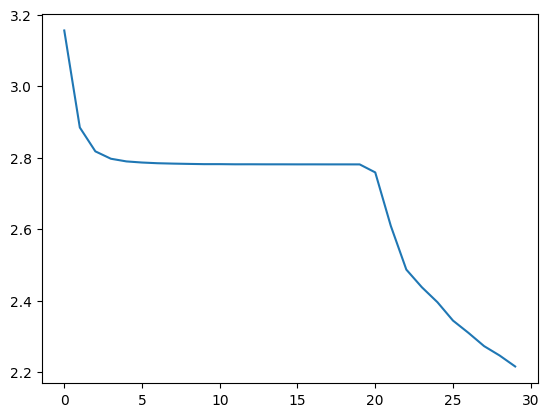

In [17]:
# Plot the Loss Curve
import matplotlib.pyplot as plt

plt.plot(history.epoch, history.history["loss"])

In [18]:
# Model structure
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          87,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 41)                  │           2,665 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 429,821 (1.64 MB)

 Trainable params: 143,273 (559.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 286,548 (1.09 MB)

In [81]:
input_string = [["what are y"]]

def convert(string):
  input_string = [i for i in string[0][0]]
  input_string_arr = [token_to_indx[i] for i in input_string]
  input_string_arr = pad_sequences([input_string_arr], maxlen=10, padding="pre", value=0)
  input_string_arr = tf.keras.utils.to_categorical(input_string_arr, num_classes=vocab_size)
  return input_string_arr

input_string_arr = convert(input_string)

y_preds = model.predict(input_string_arr)
print(y_preds, y_preds.shape)

probabilities = tf.argmax(y_preds, axis=1)
print(probabilities)
input_string[0].append(indx_to_token[int(probabilities)])
print(input_string)
print("".join(input_string[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[[6.9964076e-03 2.8905254e-02 1.9061049e-06 2.9198276e-03 4.9317636e-02
  2.3201257e-03 4.9003080e-07 5.3472050e-02 6.5510240e-03 8.1605350e-07
  7.1005579e-09 2.6979346e-02 7.4593105e-09 2.3733917e-06 1.6231430e-03
  1.2258956e-01 2.2521003e-06 7.9574516e-09 5.8700969e-03 3.8747757e-04
  3.3617301e-03 7.2294948e-09 2.7283156e-04 3.4379755e-04 2.4945189e-01
  1.0592896e-02 3.7329937e-06 7.7454709e-09 2.0854352e-03 2.4850560e-02
  6.4340453e-03 6.1110442e-04 8.8123952e-06 2.6252335e-03 1.7526187e-01
  7.3601978e-09 2.4026001e-03 7.2851782e-03 6.4833625e-03 1.2876472e-02
  1.8710861e-01]] (1, 41)
tf.Tensor([24], shape=(1,), dtype=int64)
[['what are y', 'e']]
what are ye


In [98]:
def sort(ran, y_preds):
  arr = []
  for i in range(ran):
    p = tf.argmax(y_preds, axis=1)
    arr.append(p)
    y_preds[0][p] = 0
  return arr

IndexError: list index out of range

In [123]:
import random

loop_string = [["what are y"]]
arr_input = convert(loop_string)

def predict_loop(string_input, arr_input, output_length, creativity=1):
  for i in range(output_length):
    y_preds = model.predict(arr_input)

    labels = sort(creativity, y_preds)
    label = labels[random.randint(0, creativity - 1)]

    predicted_word = indx_to_token[int(label)]
    string_input[0].append(predicted_word)
    string_input = [["".join(string_input[0])]]

    new_string = [[string_input[0][0][i + 1:]]]
    print(new_string)

    arr_input = convert(new_string)

  return string_input[0][0]


In [124]:
predict_loop(loop_string, arr_input, 10, creativity=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[['hat are ye']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[['at are yea']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[['t are year']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[' are year ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[['are year o']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[['re year os']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[['e year os ']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[' year os a']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[['year os ar']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[['ear os ari']]


'what are year os ari'

In [ ]:
# Evaluating the model
model.evaluate(X_test_cat, y_test_cat)

In [ ]:
model.save("model_0.keras")